In [1]:
%run common.ipynb

['LC_Type1', 'LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LC_Type1']


In [19]:
%run tuning_common.ipynb

In [3]:
MODEL_WORK_DIR = f'{MODEL_FOLDER}downstream-catboost/'
MODEL_SAVE_DIR = f'{MODEL_WORK_DIR}model/'

In [4]:
downstream_train_df = pd.read_csv(f'{DATA_FOLDER}{DOWNSTREAM_TRAIN_FILENAME}')
downstream_test_df = pd.read_csv(f'{DATA_FOLDER}{DOWNSTREAM_TEST_FILENAME}')

In [5]:
downstream_train_df = embed_catgorical_features(downstream_train_df, CATEGORICAL_FEATURES)
downstream_test_df = embed_catgorical_features(downstream_test_df, CATEGORICAL_FEATURES)

In [6]:
from sklearn.model_selection import train_test_split
split_train_df, split_val_df = train_test_split(downstream_train_df, test_size=0.2, shuffle=True, random_state=8)

In [7]:
from catboost import CatBoost

In [14]:
n_iter_search = 100

model = CatBoost()

param_dist = {
    'learning_rate': [0.03, 0.1],
    'depth': [2,3,4,6,8,10],
    'subsample':[i/10.0 for i in range(6,11)],
    'iterations':[128, 256, 512],
    'colsample_bylevel':[i/10.0 for i in range(6,11)], 
    # 'objective': ['RMSE'],
    # 'eval_metric': ['RMSE', 'R2'],
}

randomized_search_result = model.randomized_search(param_dist,
                                                   X=downstream_train_df[FEATURES],
                                                   y=downstream_train_df[TARGET_FEATURE],
                                                   cv=5,
                                                   n_iter=n_iter_search,
                                                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 10896.1538016	test: 11839.2951930	best: 11839.2951930 (0)	total: 49.3ms	remaining: 6.25s
1:	learn: 10078.7603105	test: 10994.5134205	best: 10994.5134205 (1)	total: 51.3ms	remaining: 3.23s
2:	learn: 9330.0807124	test: 10238.8007874	best: 10238.8007874 (2)	total: 53.9ms	remaining: 2.25s
3:	learn: 8658.8043616	test: 9555.3830256	best: 9555.3830256 (3)	total: 56.2ms	remaining: 1.74s
4:	learn: 8038.2764278	test: 8932.6226017	best: 8932.6226017 (4)	total: 58.9ms	remaining: 1.45s
5:	learn: 7507.8954629	test: 8394.1426721	best: 8394.1426721 (5)	total: 60.7ms	remaining: 1.23s
6:	learn: 7043.6061555	test: 7918.5283180	best: 7918.5283180 (6)	total: 62.5ms	remaining: 1.08s
7:	learn: 6653.4285734	test: 7511.6387095	best: 7511.6387095 (7)	total: 63.3ms	remaining: 950ms
8:	learn: 6290.4329552	test: 7122.2091481	best: 7122.2091481 (8)	total: 66.5ms	remaining: 880ms
9:	learn: 5984.3627635	test: 6803.9173810	best: 6803.9173810 (9)	total: 68.5ms	remaining: 809ms
10:	learn: 5713.0026042	test: 65

In [22]:
model.save_model(f'{MODEL_SAVE_DIR}model.json', format="json")

In [29]:
%run tuning_common.ipynb

RMSE prediction: 3873.608
RMSE MOD17: 4558.2222
R-Squared prediction: 0.6395533137895855
R-Squared MOD17: 0.5008849321193556
Max error prediction: 13520.283346422539
Max error MOD17: 15912.398000000001
Mean poisson deviance prediction: 1258.1506047165824
Mean poisson deviance MOD17: 1801.4410281845032
Mean gamma deviance prediction: 0.14115154744654557
Mean gamma deviance MOD17: 0.23879277131357057
Mean pinball loss with alpha = 0.9 prediction: 1437.035335047854
Mean pinball loss with alpha = 0.9 MOD17: 2459.509443899549
Mean pinball loss with alpha = 0.09999999999999998 prediction: 1318.5429971314438
Mean pinball loss with alpha = 0.09999999999999998 MOD17: 942.2346256023698


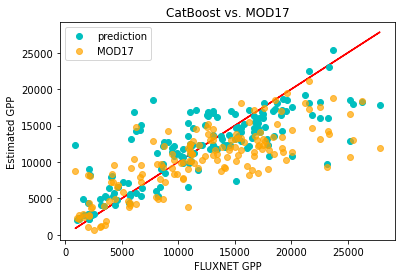

In [30]:
model = CatBoost()      # parameters not required.
model.load_model(f'{MODEL_SAVE_DIR}model.json', format="json")
y_pred = model.predict(downstream_test_df[FEATURES])
modis_compare_data = get_modis_compare_data(y_pred)
get_all_metrics(y_pred, modis_compare_data[TARGET_FEATURE], downstream_test_df[TARGET_FEATURE])
plot_result_distribution(downstream_test_df[TARGET_FEATURE], y_pred, modis_compare_data[TARGET_FEATURE], save_dir=f'{MODEL_RESULT_PLT_DIR}CatBoost.png', title='CatBoost vs. MOD17')